## Find optimal anchor boxes for YOLOv2

Extracts the widths and heights of all bounding boxes in the COCO training dataset and runs k-means clustering with a IoU distance to find the optimal anchor boxes.

In [19]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import json
from pycocotools.coco import COCO
from anchor_boxes import *

In [11]:
# Load annotations and extract bboxes
data_dir="../../cocodata/"
data_type = "train2017"
ann_file=f"{data_dir}/annotations/instances_{data_type}.json"
coco = COCO(ann_file)
cat_ids = coco.getCatIds(catNms=['any'])
img_ids = coco.getImgIds(catIds=cat_ids)
bbox_wh = []
for img_id in img_ids:
    img_info = coco.loadImgs([img_id])[0]
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    for ann_id in ann_ids:
        annotation = coco.loadAnns([ann_id])
        bbox_wh.append([annotation[0]['bbox'][2]/img_info['width'],
                        annotation[0]['bbox'][3]/img_info['height']])
        
bbox_wh = np.asarray(bbox_wh)

# number of centroids
n_centroid=5

# k-means clustering using IoU distance
kmeans = KMeans(distanceIoU,n_centroid=n_centroid)
assignments, centroids = kmeans.cluster(bbox_wh,maxiter=200)

loading annotations into memory...
Done (t=11.03s)
creating index...
index created!
Lloyds algorithm converged in 116 iterations


*** Anchor boxes*** 
0 :  0.69 x  0.75
1 :  0.22 x  0.50
2 :  0.04 x  0.06
3 :  0.49 x  0.29
4 :  0.13 x  0.18


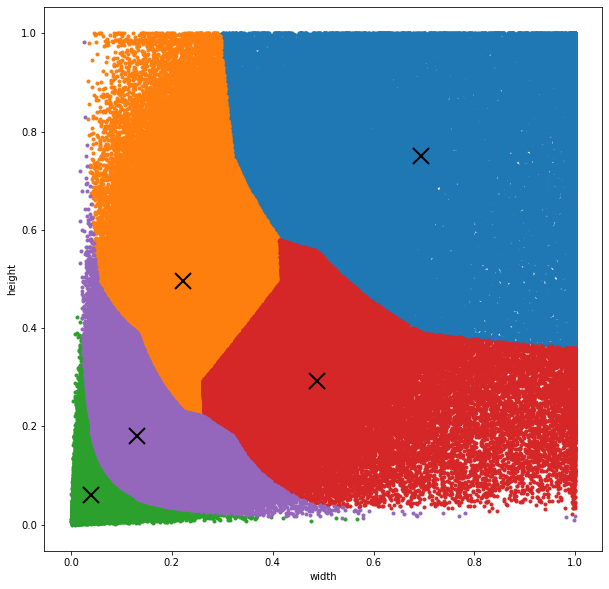

<Figure size 432x288 with 0 Axes>

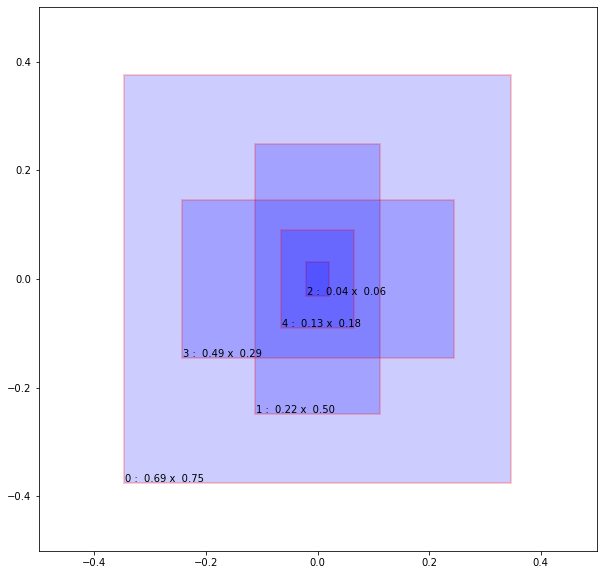

In [20]:

print ("*** Anchor boxes*** ")
for j,centroid in enumerate(centroids):
    print (f"{j} : {centroid[0]:5.2f} x {centroid[1]:5.2f}")

# visualise clustered data
plot_kmeans_data(bbox_wh, assignments, centroids,label_x='width',label_y='height')

# visualise bounding boxes
plt.clf()
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlim(-0.5,+0.5)
ax.set_ylim(-0.5,+0.5)
for j,centroid in enumerate(centroids):
    w,h = centroid[0], centroid[1]
    x,y = -0.5*w,-0.5*h
    ax.add_patch(mpl.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='red',facecolor='blue',alpha=0.2))
    plt.text(x+0.002,y+0.002,f"{j} : {centroid[0]:5.2f} x {centroid[1]:5.2f}")
plt.show()

# Save to json as a dictionary
anchor_boxes = []
for anchor_box in centroids:
    anchor_boxes.append({'width':centroid[0],'height':centroid[1]})
with open('anchor_boxes.json','w',encoding='utf8') as f:
    json.dump(anchor_boxes,f)